## import library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras import regularizers
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.layers import Conv2D
from keras.layers import BatchNormalization
from keras.layers import Flatten
from keras.callbacks import LearningRateScheduler
from tensorflow.keras import datasets
import keras


from keras.layers import Conv2D, Lambda, MaxPooling2D # convolution layers
from keras.layers import Dense, Dropout, Flatten # core layers

## Load mnist data

In [2]:
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

## split train | validation

In [3]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((48000, 28, 28), (48000,), (12000, 28, 28), (12000,))

## encoding multi class label

In [4]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

print(f"Train Label size {y_train.shape}")
print(f"Validation Label size {y_val.shape}")

Train Label size (48000, 10)
Validation Label size (12000, 10)


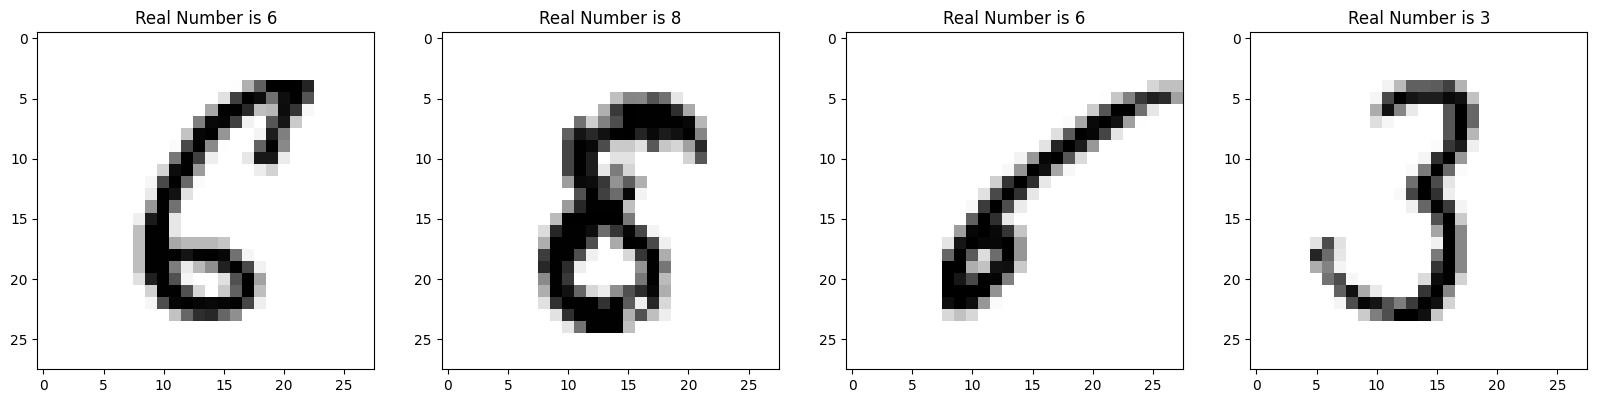

In [5]:
x_train__ = x_train.reshape(x_train.shape[0], 28, 28)

fig, axis = plt.subplots(1, 4, figsize=(20, 10))
for i, ax in enumerate(axis.flat):
    ax.imshow(x_train__[i], cmap='binary')
    digit = y_train[i].argmax()
    ax.set(title = f"Real Number is {digit}");

## normalisation 

In [6]:
mean = np.mean(x_train)
std = np.std(x_train)
mean = np.mean(x_val)
std = np.std(x_val)
def standardize(x):
    return (x-mean)/std

## define the model

In [7]:
model=Sequential()


model.add(Lambda(standardize,input_shape=(28,28,1)))    
model.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu", input_shape=(28,28,1)))
model.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
model.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())    

model.add(Conv2D(filters=256, kernel_size = (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
    
model.add(Flatten())
model.add(Dense(512,activation="relu"))
    
model.add(Dense(10,activation="softmax"))
    
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 12, 12, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 128)       7

## early stopping & reduceLROnPlateau

In [9]:
epochs = 2
batch_size = 128
train_steps = x_train.shape[0] // batch_size
valid_steps = x_val.shape[0] // batch_size

es = keras.callbacks.EarlyStopping(
        monitor="val_loss", # metrics to monitor
        patience=2, # how many epochs before stop
        verbose=2,
        mode="max", # we need the maximum accuracy.
        restore_best_weights=False, # 
     )

rp = keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.1,
        patience=1,
        verbose=2,
        mode="max",
        min_lr=0.00001,
     )

In [10]:
# Fit the model
history = model.fit(x_train, y_train,
                              epochs = epochs, 
                              steps_per_epoch = train_steps,
                              validation_data = (x_val, y_val),
                              validation_steps = valid_steps, 
                              callbacks=[es, rp])

Epoch 1/2
375/375 [==============================] - 240s 634ms/step - loss: 0.0898 - accuracy: 0.9727 - val_loss: 0.1048 - val_accuracy: 0.9675 - lr: 0.0010
Epoch 2/2
375/375 [==============================] - ETA: 0s - loss: 0.0323 - accuracy: 0.9904
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
375/375 [==============================] - 126s 337ms/step - loss: 0.0323 - accuracy: 0.9904 - val_loss: 0.0690 - val_accuracy: 0.9810 - lr: 0.0010


## evaluation model

In [11]:
# A FAIRE
# score = model.evaluate(x_test, y_test)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])

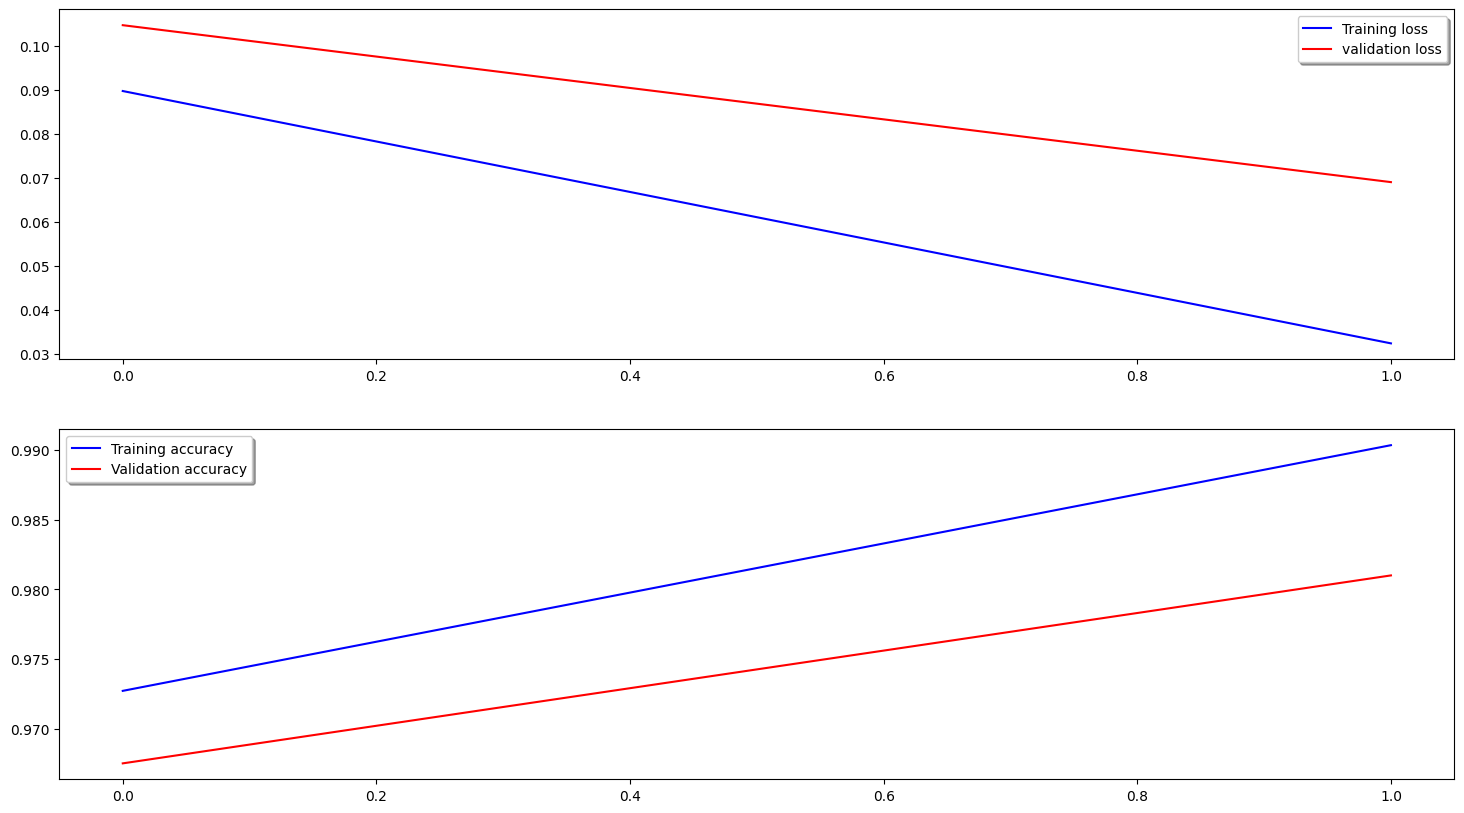

In [16]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1, figsize=(18, 10))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

## tuning model

# save model with joblib for integrate 

In [ ]:
# Calling `save('my_model')` creates a SavedModel folder `my_model`.
# model.save("my_model")